# S-Learner Tutorial

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import pyreadr

from sklearn.linear_model import LogisticRegression
from causalml.inference.meta import BaseSClassifier


In [12]:
data_read = pyreadr.read_r('/Users/pbrendel/projects/multibias/data/df_uc_source.rda')
df = data_read['df_uc_source']

df.head()

,X_bi,X_cont,Y_bi,Y_cont,C1,C2,C3,U
0,0,2.22,0,4.01,0,0,1,1
1,1,2.42,0,4.98,1,0,0,1
2,0,0.98,0,1.37,1,0,1,0
3,0,3.33,0,3.87,1,1,1,1
4,0,4.09,0,4.27,1,1,1,1


In [13]:
Y = df['Y_bi']
T = df['X_bi']
X = df[['C1', 'C2', 'C3', 'U']]

In [46]:
learner = LogisticRegression(penalty=None, solver='lbfgs')
slearner = BaseSClassifier(learner=learner)

In [50]:
slearner.fit(X=X, treatment=T, y=Y)
slearner.estimate_ate(X=X, treatment=T, y=Y)

array([0.10202636])

In [51]:
cate = slearner.predict(X)
print(np.mean(cate))

df['cate'] = cate
df.head()


0.10202636364308824


,X_bi,X_cont,Y_bi,Y_cont,C1,C2,C3,U,cate
0,0,2.22,0,4.01,0,0,1,1,0.124946
1,1,2.42,0,4.98,1,0,0,1,0.134484
2,0,0.98,0,1.37,1,0,1,0,0.106907
3,0,3.33,0,3.87,1,1,1,1,0.092905
4,0,4.09,0,4.27,1,1,1,1,0.092905


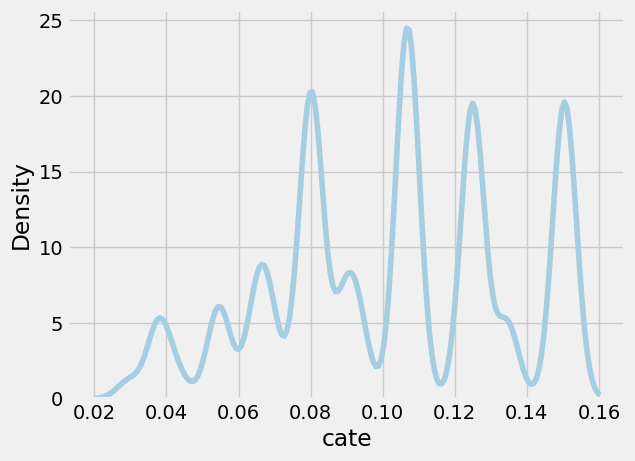

In [54]:
sns.kdeplot(data=df, x="cate");
